# Imports

In [50]:
#!pip install -U scikit-learn

In [51]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [52]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [53]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [54]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [55]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [56]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[9.37876377 9.38117911 9.37878717 ... 2.94642371 8.45490645 2.94692183]
[14.35253194 14.35622818 14.35256775 ...  4.5089781  12.93873241
  4.50974037]
[1.         1.         1.         ... 0.99953126 1.         0.99953187]
(5999,)


### Multinomial Sampling

In [57]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 0]


In [58]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(80.08181, 8.237194, 1.2106892), (80.21036, 8.237194, 1.4801991), (79.978134, 7.9794145, 2.7418654), (87.85114, -2.3044074, 92.771225), (75.45033, -6.5098743, 0.95672005), (77.642975, -7.6759295, 84.837746), (86.42414, -8.399635, 42.5), (76.56786, -6.5098743, 1.3857008), (75.0, -0.33300498, -13.793697), (84.50007, -1.6554987, 95.82883), (85.97716, -1.6554987, 94.75566), (77.47216, -7.328478, 84.25287), (75.0, -6.2811418, -11.163381), (75.21826, -1.9813722, 81.258484), (75.78312, -6.2811418, -11.142874), (77.13951, -7.328478, 84.49455), (76.47152, -4.871695, 55.4), (75.0, -4.1574683, -12.755995), (75.07711, -1.1623888, 55.4), (83.853294, 8.535009, 87.63229), (75.03937, 0.8314692, 55.4), (76.21391, -7.328478, 0.06395996), (76.01672, -7.328478, 0.0055487785), (79.39824, -7.6759295, 2.865125), (77.07002, 7.9794145, -0.8493497), (75.020386, 0.66553295, 81.21481), (77.08136, -6.0434117, 82.40167), (76.5117, 5.0095077, 3.394941), (75.05033, 1.3272538, 3.71282), (51.0, 8.642877, -3.3445013), 

# KNN

In [59]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[80.08181, 8.237194, 1.2106892], [80.21036, 8.237194, 1.4801991], [79.978134, 7.9794145, 2.7418654], [87.85114, -2.3044074, 92.771225], [75.45033, -6.5098743, 0.95672005], [77.642975, -7.6759295, 84.837746], [86.42414, -8.399635, 42.5], [76.56786, -6.5098743, 1.3857008], [75.0, -0.33300498, -13.793697], [84.50007, -1.6554987, 95.82883], [85.97716, -1.6554987, 94.75566], [77.47216, -7.328478, 84.25287], [75.0, -6.2811418, -11.163381], [75.21826, -1.9813722, 81.258484], [75.78312, -6.2811418, -11.142874], [77.13951, -7.328478, 84.49455], [76.47152, -4.871695, 55.4], [75.0, -4.1574683, -12.755995], [75.07711, -1.1623888, 55.4], [83.853294, 8.535009, 87.63229], [75.03937, 0.8314692, 55.4], [76.21391, -7.328478, 0.06395996], [76.01672, -7.328478, 0.0055487785], [79.39824, -7.6759295, 2.865125], [77.07002, 7.9794145, -0.8493497], [75.020386, 0.66553295, 81.21481], [77.08136, -6.0434117, 82.40167], [76.5117, 5.0095077, 3.394941], [75.05033, 1.3272538, 3.71282], [51.0, 8.642877, -3.3445013], 

In [60]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = tuple(XYZ[poly[index_current_node]])
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, tuple(XYZ[poly[index_other_node]])
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [61]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  5


Number of nodes: 50
Number of edges: 182


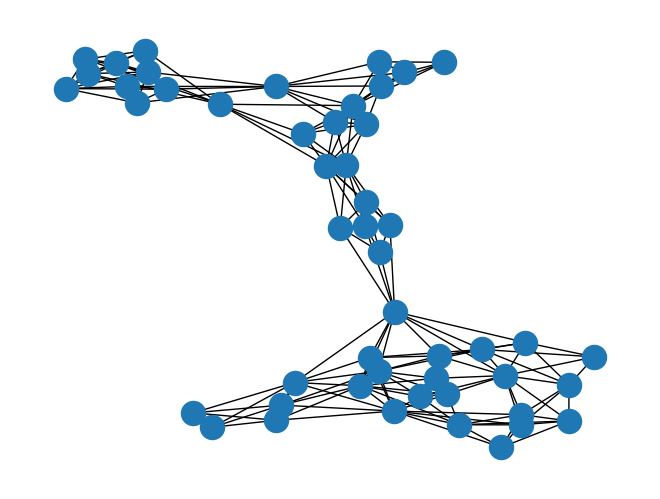

In [62]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [63]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [64]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\Arthur\AppData\Local\Temp\ipykernel_3436\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

#### Inputs

In [65]:
adjacency = nx.adjacency_matrix(extended_graph)
S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 25)	1
  (0, 26)	1
  (0, 29)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (2, 0)	1
  (2, 1)	1
  (2, 3)	1
  (2, 4)	1
  (2, 42)	1
  (2, 43)	1
  (3, 0)	1
  (3, 1)	1
  (3, 2)	1
  (3, 4)	1
  (3, 25)	1
  (3, 26)	1
  (3, 29)	1
  (3, 42)	1
  :	:
  (46, 42)	1
  (46, 45)	1
  (46, 47)	1
  (47, 3)	1
  (47, 10)	1
  (47, 12)	1
  (47, 14)	1
  (47, 27)	1
  (47, 42)	1
  (47, 45)	1
  (47, 46)	1
  (48, 16)	1
  (48, 19)	1
  (48, 30)	1
  (48, 31)	1
  (48, 32)	1
  (48, 33)	1
  (48, 49)	1
  (49, 16)	1
  (49, 19)	1
  (49, 30)	1
  (49, 31)	1
  (49, 32)	1
  (49, 33)	1
  (49, 48)	1
[[0.54392572 0.04134765 0.32599859 ... 0.97324543 0.05718942 0.54341157]
 [0.1724395  0.70612341 0.77019872 ... 0.985547   0.40992562 0.31798656]
 [0.24678704 0.85738059 0.23179021 ... 0.85995507 0.97126168 0.25306263]
 ...
 [0.8572858  0.18286457 0.43477978 ... 0.0827251  0.54010283 0.45955426]
 [0.00157718 0.51916825 0.41394971 ... 0.75808817 0.52889034 0.06285004]
 [0.98026741 0.3

In [66]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

[[ 90.64526825  98.16652401  96.64922211 ... 107.21714641  89.64877817
  102.73095574]
 [ 98.16652401 101.25600577 106.38158877 ... 113.57089777  97.11895184
  107.41482584]
 [ 96.64922211 106.38158877 107.98425152 ... 120.61745832  96.09285319
  107.55755433]
 ...
 [107.21714641 113.57089777 120.61745832 ... 129.21390136 109.71273148
  118.92869282]
 [ 89.64877817  97.11895184  96.09285319 ... 109.71273148  88.77154229
   99.76971071]
 [102.73095574 107.41482584 107.55755433 ... 118.92869282  99.76971071
  111.51915512]]
(50, 50)


c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


# Face Classifier

### TriConv

#### Inputs

In [67]:
triangles = list(nx.simple_cycles(extended_graph, length_bound=3))  # [triangle0, triangle1,...] | triangle0 = [node1,node2,node3] | node1 = (x ,y ,z)
print(triangles)
print(np.array(triangles).shape)    #nb_triangle, 3 nodes, 3 dimensions par node

[[(76.01672, -7.328478, 0.0055487785), (75.45033, -6.5098743, 0.95672005), (76.56786, -6.5098743, 1.3857008)], [(76.01672, -7.328478, 0.0055487785), (75.45033, -6.5098743, 0.95672005), (76.21391, -7.328478, 0.06395996)], [(76.01672, -7.328478, 0.0055487785), (75.45033, -6.5098743, 0.95672005), (75.40506, -5.0095077, 2.2882998)], [(76.01672, -7.328478, 0.0055487785), (75.45033, -6.5098743, 0.95672005), (78.77108, -7.6759295, 1.3510301)], [(76.01672, -7.328478, 0.0055487785), (75.45033, -6.5098743, 0.95672005), (51.0, -6.3966537, 1.0434115)], [(76.01672, -7.328478, 0.0055487785), (75.45033, -6.5098743, 0.95672005), (63.0, -8.8, -5.0)], [(76.01672, -7.328478, 0.0055487785), (75.45033, -6.5098743, 0.95672005), (75.0, -6.2811418, -11.163381)], [(76.01672, -7.328478, 0.0055487785), (75.45033, -6.5098743, 0.95672005), (75.53943, -3.2518802, 3.4885595)], [(80.21036, 8.237194, 1.4801991), (80.08181, 8.237194, 1.2106892), (79.978134, 7.9794145, 2.7418654)], [(80.21036, 8.237194, 1.4801991), (80.

In [97]:
p_init = np.zeros((len(triangles)))

for index_triangle, triangle in enumerate(triangles):
    i = list(dict(extended_graph._node).keys()).index(triangle[0])
    j = list(dict(extended_graph._node).keys()).index(triangle[1])
    k = list(dict(extended_graph._node).keys()).index(triangle[2])
    p_init[index_triangle] = (A_s[i,j] + A_s[i,k] + A_s[j,k])/3
print(p_init)

[ 98.55779993  92.80660177  91.63712893  93.15919853  95.0325589
 100.89041141  88.84802569  89.23600406 100.39911163  88.08692344
  90.99091268 103.45244937 101.341286   106.2845157   98.68396157
  93.95495118  97.45232851  95.80420868  98.37354242  84.70198187
  92.24389851  99.3914624  106.16678738  94.03854036  87.43692565
  85.2235432  103.5124712   96.62169309  88.59535138  82.91179745
  90.49346962 109.49178894  88.44635944  79.88086163  76.5511995
  85.49578567  79.17954662  86.73359536  91.77782902  90.906114
  82.9735971   81.94050072  87.45725893  80.59838732  90.71273627
  97.22304448  83.22106523  89.53812753 100.3216326   78.11604223
  73.91899385  80.94640745  91.65155557  94.97333044  95.23033008
  90.66316829  91.17839225  86.65835616  91.52700499  86.19268728
  87.81051499 100.53796926  95.80370029  91.69553554  98.7948911
 105.36024975  88.03932987  91.58117627  91.29481628  97.170503
 108.84098128  82.48502553  85.53993534  79.39021432  79.84202271
  74.81579179  75

#### Calculate barycenter

In [68]:
barycenters = list()

for _, triangle in enumerate(triangles):
    b_x = (triangle[0][0] + triangle[1][0] + triangle[2][0]) / 3
    b_y = (triangle[0][1] + triangle[1][1] + triangle[2][1]) / 3
    b_z = (triangle[0][2] + triangle[1][2] + triangle[2][2]) / 3
    barycenters.append([b_x, b_y, b_z])

print(barycenters)
print(len(barycenters))

[[76.01163736979167, -6.782742182413737, 0.7826565106709799], [75.89365641276042, -7.055610020955403, 0.34207626183827716], [75.62403869628906, -6.282620112101237, 1.083522876103719], [76.7460428873698, -7.171427408854167, 0.7710996468861898], [67.48901875813802, -6.745002110799153, 0.6685601075490316], [71.48901875813802, -7.5461171468098955, -1.3459103902180989], [75.48901875813802, -6.70649782816569, -3.4003705978393555], [75.66882832845052, -5.696744283040364, 1.4836095174153645], [80.09010314941406, 8.151267369588217, 1.810917854309082], [79.12073262532552, 8.151267369588217, 0.613846222559611], [78.93462626139323, 7.161298751831055, 2.0286099116007485], [76.26616923014323, -7.055610020955403, 0.4850698709487915], [75.99655151367188, -6.282620112101237, 1.2265164852142334], [77.11856079101562, -7.171427408854167, 0.9140932559967041], [76.04134114583333, -5.696744283040364, 1.626603126525879], [79.08617146809895, 8.065340677897135, 1.1242382526397705], [78.90006510416667, 7.0753720

In [69]:
def connect_triangle_graph(XYZ, number_neigh=20):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [80]:
graph_triangles = connect_triangle_graph(barycenters)
print(graph_triangles._node)

{(76.01163736979167, -6.782742182413737, 0.7826565106709799): {'index_poly': {0, 1, 2, 3, 5, 6, 7, 11, 12, 13, 14, 17, 18, 20, 22, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 98, 99, 100, 101, 102, 103, 104, 105, 107, 114}}, (76.07737223307292, -6.782742182413737, 0.802126963933309): {'index_poly': {0, 1, 2, 3, 5, 6, 7, 11, 12, 13, 14, 17, 18, 20, 22, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 98, 99, 100, 101, 102, 103, 104, 105, 107, 114}}, (75.87856547037761, -6.555487950642903, 0.785936196645101): {'index_poly': {0, 1, 2, 3, 5, 6, 7, 11, 12, 13, 14, 17, 18, 20, 22, 82, 83, 84, 85, 86, 88, 92, 102, 103, 104, 105, 107, 114}}, (76.26616923014323, -7.055610020955403, 0.4850698709487915): {'index_poly': {0, 1, 2, 3, 5, 6, 7, 11, 12, 13, 14, 17, 18, 22, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 98, 99, 100, 101, 102, 103, 104, 112}}, (75.89365641276042, -7.055610020955403, 0.34207626183827716): {'index_poly': {0, 1, 2, 3, 5, 6, 7, 11, 12, 13, 17, 18, 22, 25, 26, 82, 83, 84, 85, 86, 88, 90, 91, 10

In [71]:
transformation.print_graph_properties(graph=graph_triangles, display_graph=False, display_labels=False)

Number of nodes: 247
Number of edges: 4710


#### calculate e norm matrix

In [72]:
diff_vectors = list()

for _, triangle in enumerate(triangles):
    e_ij = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[1]))
    e_ik = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[2]))
    e_jk = np.linalg.norm(np.array(triangle[1]) - np.array(triangle[2]))
    diff_vectors.append([e_ij, e_ik, e_jk])
print(diff_vectors)
print(len(diff_vectors))

[[1.3768214, 1.6966692, 1.1970378], [1.3768214, 0.2056587, 1.4318476], [1.3768214, 3.310998, 2.006553], [1.3768214, 3.0850482, 3.5415432], [1.3768214, 25.055576, 24.450748], [1.3768214, 14.023409, 13.990639], [1.3768214, 11.263907, 12.130621], [1.3768214, 5.3831053, 4.127066], [0.29859686, 1.3085029, 1.5561811], [0.29859686, 3.9185395, 3.658015], [0.29859686, 5.269178, 5.285317], [1.6966692, 0.2056587, 1.5944879], [1.6966692, 3.310998, 2.1018796], [1.6966692, 3.0850482, 2.4930003], [1.6966692, 5.3831053, 4.01176], [1.3085029, 3.9185395, 4.621032], [1.3085029, 5.269178, 4.6111817], [0.2056587, 3.310998, 3.313541], [0.2056587, 3.0850482, 2.8838127], [3.9185395, 5.269178, 5.210189], [3.310998, 5.3831053, 2.1325881], [3.310998, 25.055576, 24.47613], [3.310998, 14.023409, 14.878597], [11.263907, 15.504501, 6.5037603], [11.263907, 13.18886, 2.6545072], [11.263907, 11.199946, 0.78338766], [11.263907, 14.023409, 13.723408], [11.263907, 25.055576, 26.92618], [11.199946, 15.504501, 6.5589995], [

#### Calculate r

In [73]:
r_matrix = np.zeros((len(triangles),len(triangles), 5))

for n, triangle_n in enumerate(triangles):
    for m, triangle_m in enumerate(triangles):
        t_min = min(diff_vectors[n]) - min(diff_vectors[m])
        t_max = max(diff_vectors[n]) - max(diff_vectors[m])
        diff_bary = np.array(barycenters[n]) - np.array(barycenters[m])
        r_matrix[n, m] = [t_min, t_max, diff_bary[0], diff_bary[1], diff_bary[2]]

print(r_matrix)
print(r_matrix.shape)   # nb_triangles, nb_triangles, 5dim/triangles

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 9.91379142e-01  2.64821649e-01  1.17980957e-01  2.72867839e-01
    4.40580249e-01]
  [-1.79783583e-01 -1.61432874e+00  3.87598674e-01 -5.00122070e-01
   -3.00866365e-01]
  ...
  [-6.56310606e+00 -1.08658810e+01 -2.26337687e+00 -1.29480076e+01
   -8.42844059e+01]
  [ 4.95623946e-01 -1.28912699e+00 -1.38719686e+00  2.33197530e-01
   -8.30481032e+01]
  [ 4.95623946e-01 -3.17596149e+00 -1.09167480e+00  1.12635803e+00
   -8.51620660e+01]]

 [[-9.91379142e-01 -2.64821649e-01 -1.17980957e-01 -2.72867839e-01
   -4.40580249e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [-1.17116272e+00 -1.87915039e+00  2.69617716e-01 -7.72989909e-01
   -7.41446614e-01]
  ...
  [-7.55448484e+00 -1.11307030e+01 -2.38135783e+00 -1.32208754e+01
   -8.47249861e+01]
  [-4.95755166e-01 -1.55394864e+00 -1.50517782e+00 -3.96703084e-02
   -8.34886834e+01]
  [-4.95755166e-01 -3.4407830

#### Calculate f

In [109]:
# MLP * 3 
f_final = p_init    # TODO

import torch
final_scores = torch.nn.functional.softmax(torch.tensor(f_final))
final_scores = final_scores.numpy()
print(final_scores.sum())
print(final_scores.shape)
print(final_scores)

0.9999999999999999
(247,)
[4.63928034e-06 1.47481313e-08 4.57974597e-09 2.09830116e-08
 1.36602263e-07 4.78069364e-05 2.81545926e-10 4.14998102e-10
 2.92497479e-05 1.31524524e-10 2.39990053e-09 6.19683394e-04
 7.50418029e-05 1.05225413e-02 5.26310365e-06 4.65006267e-08
 1.53585593e-06 2.95516089e-07 3.85858966e-06 4.45600114e-12
 8.40152402e-09 1.06783863e-05 9.35388188e-03 5.05546517e-08
 6.86619740e-11 7.50682862e-12 6.58016843e-04 6.69283474e-07
 2.18682578e-10 7.43837516e-13 1.45933993e-09 2.60028954e-01
 1.88411675e-10 3.59053675e-14 1.28559888e-15 9.85575503e-12
 1.78066465e-14 3.39831647e-11 5.27165114e-09 2.20478192e-09
 7.91256560e-13 2.81610775e-13 7.00723879e-11 7.35828868e-14
 1.81711644e-09 1.22116315e-06 1.01342443e-12 5.61379651e-10
 2.70690748e-05 6.14763463e-15 9.24598310e-17 1.04212555e-13
 4.64629522e-09 1.28746460e-07 1.66474924e-07 1.72924155e-09
 2.89477345e-09 3.15201192e-11 4.10218435e-09 1.97856548e-11
 9.97617534e-11 3.36068053e-05 2.95365890e-07 4.85519927e-0

C:\Users\Arthur\AppData\Local\Temp\ipykernel_3436\4023725568.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_scores = torch.nn.functional.softmax(torch.tensor(f_final))


# Simplified Mesh